In [1]:
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict
import os
import seaborn as sns

/home/icb/dominik.klein/mambaforge/envs/cfp/lib/python3.11/site-packages/optuna/study/_optimize.py:29: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from optuna import progress_bar as pbar_module


In [2]:
output_dir = "/lustre/groups/ml01/workspace/ot_perturbation/figures/zebrafish/temporal_problem/cell_type_proportions_true"

In [3]:
adata = sc.read_h5ad("/lustre/groups/ml01/workspace/ot_perturbation/data/zebrafish_new/zebrafish_processed.h5ad")

In [4]:
bdata = adata[(adata.obs["tissue"]=="Central Nervous System") & (adata.obs["timepoint"]<37.0) & (adata.obs["gene_target"].isin(("control_control", "cdx4_cdx1a")))]

In [5]:
cts_ordered = pd.read_csv("/lustre/groups/ml01/workspace/ot_perturbation/data/zebrafish_new/cell_types_ordered.csv", index_col=0)

In [6]:
cts = list(bdata.obs["cell_type_broad"].unique())

cts = [el for el in cts_ordered["CTs"] if el in list(bdata.obs["cell_type_broad"].unique())]

In [7]:
wandb_name = "fresh-field-2"


df_ctrl = pd.read_csv(f"/lustre/groups/ml01/workspace/cell_flow_zebrafish/results/single_condition/interpolate_time_cns/interpolated_control_control_24_{wandb_name}_obs.csv")
df_pert = pd.read_csv(f"/lustre/groups/ml01/workspace/cell_flow_zebrafish/results/single_condition/interpolate_time_cns/interpolated_cdx4_cdx1a_24_{wandb_name}_obs.csv")

In [8]:
df_ctrl_timepoint = df_ctrl.groupby(["condition"])["cell_type_broad"].value_counts(normalize=True).to_frame(name="fraction").reset_index()
df_pert_timepoint = df_pert.groupby(["condition"])["cell_type_broad"].value_counts(normalize=True).to_frame(name="fraction").reset_index()


In [9]:
df_ctrl_timepoint["mode"] = "control_control"
df_pert_timepoint["mode"] = "cdx4_cdx1a"

In [10]:
df_pred = pd.concat((df_ctrl_timepoint, df_pert_timepoint))

In [11]:
df_pred["timepoint"] = df_pred.apply(lambda x: x["condition"].split("_")[-1], axis=1)

In [12]:
df = bdata.obs[bdata.obs["gene_target"].isin(("control_control", "cdx4_cdx1a"))]
df["Oligo"] = df["Oligo"].cat.remove_unused_categories()


In [13]:
df_oligo = df.groupby(["Oligo"])["cell_type_broad"].value_counts(normalize=True).to_frame(name="fraction").reset_index()


/tmp/ipykernel_3778751/159176499.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_oligo = df.groupby(["Oligo"])["cell_type_broad"].value_counts(normalize=True).to_frame(name="fraction").reset_index()


In [14]:
df_oligo["timepoint"] = df_oligo.apply(lambda x: int(x["Oligo"].split("h")[0]), axis=1)
df_oligo["gene_target"] = df_oligo.apply(lambda x: "cdx4_cdx1a" if "cdx4-cdx1a" in x["Oligo"] else "control_control", axis=1)

In [15]:
df_timepoint = df.groupby(["timepoint", "gene_target"])["cell_type_broad"].value_counts(normalize=True).to_frame(name="fraction").reset_index()

/tmp/ipykernel_3778751/2328963825.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_timepoint = df.groupby(["timepoint", "gene_target"])["cell_type_broad"].value_counts(normalize=True).to_frame(name="fraction").reset_index()


In [16]:
df_timepoint["timepoint"].value_counts()

timepoint
18.0    50
24.0    50
36.0    50
Name: count, dtype: int64

In [17]:
df_timepoint["gene_target"].value_counts()

gene_target
cdx4_cdx1a         75
control_control    75
Name: count, dtype: int64

In [18]:
df_timepoint["Oligo"] = "total"

In [19]:
df_true = pd.concat((df_oligo, df_timepoint))

In [20]:
df_true["timepoint"].value_counts()

timepoint
36.0    1350
24.0    1150
18.0     925
Name: count, dtype: int64

In [21]:
cell_type_selected = "neural progenitor (hindbrain R7/8)"

In [22]:
df_pred["timepoint"] = df_pred["timepoint"].astype(float)

# Plotting


In [23]:
color_d = {'control_control': '#4b4b4b', 'cdx4_cdx1a': '#CE2D4F'}

In [24]:
cell_types_selection = bdata.obs["cell_type_broad"].unique()

In [25]:
cell_types_selection = bdata.obs["cell_type_broad"].unique()

In [26]:
cell_types_selection

['neural progenitor (hindbrain R7/8)', 'neural progenitor (diencephalon/telencephalon)', 'neurons (differentiating, contains peripheral)', 'neural progenitor (MHB)', 'neural progenitor (hindbrain)', ..., 'roof plate, flexural + subcommissural organ', 'neuron (cranial ganglia sensory, Rohon-Beard)', 'dorsal spinal cord neuron', 'neuron (dopaminergic)', 'unknown (k+ channel, ciliated)']
Length: 25
Categories (25, object): ['KA neuron', 'differentiating neuron 1', 'differentiating neuron 2', 'differentiating neuron (hindbrain)', ..., 'neurons (gabaergic, glutamatergic; contains P..., 'posterior spinal cord progenitors', 'roof plate, flexural + subcommissural organ', 'unknown (k+ channel, ciliated)']

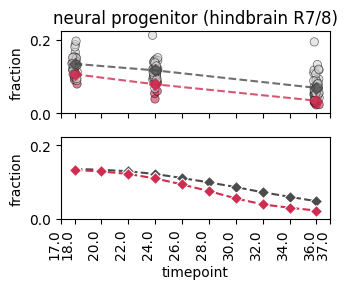

In [27]:
cell_type_selected = cell_types_selection[0]

df_subset1 = df_true[df_true["cell_type_broad"] == cell_type_selected]
df_subset2 = df_pred[df_pred["cell_type_broad"] == cell_type_selected]

df_highlight = df_subset1[df_subset1["Oligo"]=="total"]



all_timepoints = np.linspace(18, 36, 10)
all_timepoints = np.array([17.0] + list(all_timepoints) + [37.0])

jitter_strength = 0.2  # Adjust this value as needed

# Copy dataframe and add jitter to x-axis
df_subset_jittered = df_subset1.copy()
df_subset_jittered["timepoint_jittered"] = df_subset1["timepoint"] + np.random.uniform(-jitter_strength, jitter_strength, size=len(df_subset1))

# Define explicit y-range based on both datasets
ymin = 0.0 #min(df_subset["fraction"].min(), df_subset2["fraction"].min()) * 0.95  # Add slight buffer
ymax = max(df_subset1["fraction"].max(), df_subset2["fraction"].max()) * 1.05  # Add slight buffer

# Create figure with two subplots (stacked)
fig, axes = plt.subplots(2, 1, figsize=(3.5, 3), sharex=True, sharey=True)

### **Upper Plot: Scatter + Line Overlay**
ax1 = axes[0]

# Scatter plot with jittered x-values
sns.scatterplot(
    data=df_subset_jittered,
    x="timepoint_jittered",
    y="fraction",
    hue="gene_target",
    alpha=0.6, 
    edgecolor="black", 
    palette={"control_control": "#D6D6D6", "cdx4_cdx1a": "#CE2D4F"}, 
    linewidth=0.5,
    legend=False,
    ax=ax1
)

# Overlay line plot
for gene_target, df_group in df_highlight.groupby("gene_target"):
    color = color_d[gene_target]
    x_values = df_group["timepoint"]
    y_values = df_group["fraction"]

    # Sort by x-values to ensure correct line plotting order
    sorted_indices = np.argsort(x_values)
    x_values = np.array(x_values)[sorted_indices]
    y_values = np.array(y_values)[sorted_indices]


    ax1.plot(x_values, y_values, marker="D", linestyle="--", color=color, alpha=0.8)

### **Lower Plot: Line Plot Based on df_subset2**
ax2 = axes[1]

sns.lineplot(
    data=df_subset2,
    x="timepoint",
    y="fraction",
    hue="mode",
    marker="D",
    linestyle="--",
    palette=color_d,
    alpha=1.0,
    legend=False,
    ax=ax2
)

# Apply explicit x/y limits
ax1.set_xlim([all_timepoints.min(), all_timepoints.max()])
ax2.set_xlim([all_timepoints.min(), all_timepoints.max()])
ax1.set_ylim([ymin, ymax])
ax2.set_ylim([ymin, ymax])

# Format x-axis ticks correctly
ax2.set_xticks(all_timepoints)
ax2.set_xticklabels([f"{t:.1f}" for t in all_timepoints], rotation=90, ha="right")

# Remove x-tick labels from the upper plot to avoid redundancy
ax1.set_xticklabels(all_timepoints)
ax1.set_title(f"{cell_type_selected}")

cell_type_selected = cell_type_selected.replace(" ","_").replace("/", "_")
fig.savefig(os.path.join(output_dir, f"{cell_type_selected}_evolution.pdf"), dpi=300, bbox_inches="tight")

plt.tight_layout()
plt.show()


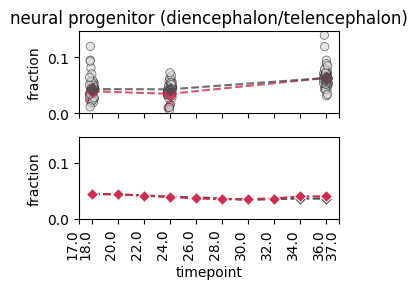

In [28]:
cell_type_selected = cell_types_selection[1]

df_subset1 = df_true[df_true["cell_type_broad"] == cell_type_selected]
df_subset2 = df_pred[df_pred["cell_type_broad"] == cell_type_selected]

df_highlight = df_subset1[df_subset1["Oligo"]=="total"]



all_timepoints = np.linspace(18, 36, 10)
all_timepoints = np.array([17.0] + list(all_timepoints) + [37.0])

jitter_strength = 0.2  # Adjust this value as needed

# Copy dataframe and add jitter to x-axis
df_subset_jittered = df_subset1.copy()
df_subset_jittered["timepoint_jittered"] = df_subset1["timepoint"] + np.random.uniform(-jitter_strength, jitter_strength, size=len(df_subset1))

# Define explicit y-range based on both datasets
ymin = 0.0 #min(df_subset["fraction"].min(), df_subset2["fraction"].min()) * 0.95  # Add slight buffer
ymax = max(df_subset1["fraction"].max(), df_subset2["fraction"].max()) * 1.05  # Add slight buffer

# Create figure with two subplots (stacked)
fig, axes = plt.subplots(2, 1, figsize=(3.5, 3), sharex=True, sharey=True)

### **Upper Plot: Scatter + Line Overlay**
ax1 = axes[0]

# Scatter plot with jittered x-values
sns.scatterplot(
    data=df_subset_jittered,
    x="timepoint_jittered",
    y="fraction",
    hue="gene_target",
    alpha=0.6, 
    edgecolor="black", 
    palette={"control_control": "#D6D6D6", "cdx4_cdx1a": "#CE2D4F"}, 
    linewidth=0.5,
    legend=False,
    ax=ax1
)

# Overlay line plot
for gene_target, df_group in df_highlight.groupby("gene_target"):
    color = color_d[gene_target]
    x_values = df_group["timepoint"]
    y_values = df_group["fraction"]

    # Sort by x-values to ensure correct line plotting order
    sorted_indices = np.argsort(x_values)
    x_values = np.array(x_values)[sorted_indices]
    y_values = np.array(y_values)[sorted_indices]


    ax1.plot(x_values, y_values, marker="D", linestyle="--", color=color, alpha=0.8)

### **Lower Plot: Line Plot Based on df_subset2**
ax2 = axes[1]

sns.lineplot(
    data=df_subset2,
    x="timepoint",
    y="fraction",
    hue="mode",
    marker="D",
    linestyle="--",
    palette=color_d,
    alpha=1.0,
    legend=False,
    ax=ax2
)

# Apply explicit x/y limits
ax1.set_xlim([all_timepoints.min(), all_timepoints.max()])
ax2.set_xlim([all_timepoints.min(), all_timepoints.max()])
ax1.set_ylim([ymin, ymax])
ax2.set_ylim([ymin, ymax])

# Format x-axis ticks correctly
ax2.set_xticks(all_timepoints)
ax2.set_xticklabels([f"{t:.1f}" for t in all_timepoints], rotation=90, ha="right")

# Remove x-tick labels from the upper plot to avoid redundancy
ax1.set_xticklabels(all_timepoints)
ax1.set_title(f"{cell_type_selected}")

cell_type_selected = cell_type_selected.replace(" ","_").replace("/", "_")
fig.savefig(os.path.join(output_dir, f"{cell_type_selected}_evolution.pdf"), dpi=300, bbox_inches="tight")


plt.tight_layout()
plt.show()


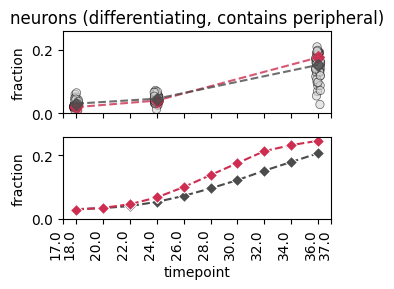

In [29]:
cell_type_selected = cell_types_selection[2]

df_subset1 = df_true[df_true["cell_type_broad"] == cell_type_selected]
df_subset2 = df_pred[df_pred["cell_type_broad"] == cell_type_selected]

df_highlight = df_subset1[df_subset1["Oligo"]=="total"]



all_timepoints = np.linspace(18, 36, 10)
all_timepoints = np.array([17.0] + list(all_timepoints) + [37.0])

jitter_strength = 0.2  # Adjust this value as needed

# Copy dataframe and add jitter to x-axis
df_subset_jittered = df_subset1.copy()
df_subset_jittered["timepoint_jittered"] = df_subset1["timepoint"] + np.random.uniform(-jitter_strength, jitter_strength, size=len(df_subset1))

# Define explicit y-range based on both datasets
ymin = 0.0 #min(df_subset["fraction"].min(), df_subset2["fraction"].min()) * 0.95  # Add slight buffer
ymax = max(df_subset1["fraction"].max(), df_subset2["fraction"].max()) * 1.05  # Add slight buffer

# Create figure with two subplots (stacked)
fig, axes = plt.subplots(2, 1, figsize=(3.5, 3), sharex=True, sharey=True)

### **Upper Plot: Scatter + Line Overlay**
ax1 = axes[0]

# Scatter plot with jittered x-values
sns.scatterplot(
    data=df_subset_jittered,
    x="timepoint_jittered",
    y="fraction",
    hue="gene_target",
    alpha=0.6, 
    edgecolor="black", 
    palette={"control_control": "#D6D6D6", "cdx4_cdx1a": "#CE2D4F"}, 
    linewidth=0.5,
    legend=False,
    ax=ax1
)

# Overlay line plot
for gene_target, df_group in df_highlight.groupby("gene_target"):
    color = color_d[gene_target]
    x_values = df_group["timepoint"]
    y_values = df_group["fraction"]

    # Sort by x-values to ensure correct line plotting order
    sorted_indices = np.argsort(x_values)
    x_values = np.array(x_values)[sorted_indices]
    y_values = np.array(y_values)[sorted_indices]


    ax1.plot(x_values, y_values, marker="D", linestyle="--", color=color, alpha=0.8)

### **Lower Plot: Line Plot Based on df_subset2**
ax2 = axes[1]

sns.lineplot(
    data=df_subset2,
    x="timepoint",
    y="fraction",
    hue="mode",
    marker="D",
    linestyle="--",
    palette=color_d,
    alpha=1.0,
    legend=False,
    ax=ax2
)

# Apply explicit x/y limits
ax1.set_xlim([all_timepoints.min(), all_timepoints.max()])
ax2.set_xlim([all_timepoints.min(), all_timepoints.max()])
ax1.set_ylim([ymin, ymax])
ax2.set_ylim([ymin, ymax])

# Format x-axis ticks correctly
ax2.set_xticks(all_timepoints)
ax2.set_xticklabels([f"{t:.1f}" for t in all_timepoints], rotation=90, ha="right")

# Remove x-tick labels from the upper plot to avoid redundancy
ax1.set_xticklabels(all_timepoints)
ax1.set_title(f"{cell_type_selected}")

cell_type_selected = cell_type_selected.replace(" ","_").replace("/", "_")
fig.savefig(os.path.join(output_dir, f"{cell_type_selected}_evolution.pdf"), dpi=300, bbox_inches="tight")

plt.tight_layout()
plt.show()


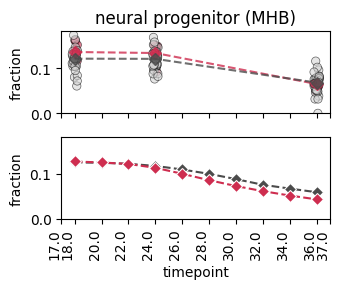

In [30]:
cell_type_selected = cell_types_selection[3]

df_subset1 = df_true[df_true["cell_type_broad"] == cell_type_selected]
df_subset2 = df_pred[df_pred["cell_type_broad"] == cell_type_selected]

df_highlight = df_subset1[df_subset1["Oligo"]=="total"]



all_timepoints = np.linspace(18, 36, 10)
all_timepoints = np.array([17.0] + list(all_timepoints) + [37.0])

jitter_strength = 0.2  # Adjust this value as needed

# Copy dataframe and add jitter to x-axis
df_subset_jittered = df_subset1.copy()
df_subset_jittered["timepoint_jittered"] = df_subset1["timepoint"] + np.random.uniform(-jitter_strength, jitter_strength, size=len(df_subset1))

# Define explicit y-range based on both datasets
ymin = 0.0 #min(df_subset["fraction"].min(), df_subset2["fraction"].min()) * 0.95  # Add slight buffer
ymax = max(df_subset1["fraction"].max(), df_subset2["fraction"].max()) * 1.05  # Add slight buffer

# Create figure with two subplots (stacked)
fig, axes = plt.subplots(2, 1, figsize=(3.5, 3), sharex=True, sharey=True)

### **Upper Plot: Scatter + Line Overlay**
ax1 = axes[0]

# Scatter plot with jittered x-values
sns.scatterplot(
    data=df_subset_jittered,
    x="timepoint_jittered",
    y="fraction",
    hue="gene_target",
    alpha=0.6, 
    edgecolor="black", 
    palette={"control_control": "#D6D6D6", "cdx4_cdx1a": "#CE2D4F"}, 
    linewidth=0.5,
    legend=False,
    ax=ax1
)

# Overlay line plot
for gene_target, df_group in df_highlight.groupby("gene_target"):
    color = color_d[gene_target]
    x_values = df_group["timepoint"]
    y_values = df_group["fraction"]

    # Sort by x-values to ensure correct line plotting order
    sorted_indices = np.argsort(x_values)
    x_values = np.array(x_values)[sorted_indices]
    y_values = np.array(y_values)[sorted_indices]


    ax1.plot(x_values, y_values, marker="D", linestyle="--", color=color, alpha=0.8)

### **Lower Plot: Line Plot Based on df_subset2**
ax2 = axes[1]

sns.lineplot(
    data=df_subset2,
    x="timepoint",
    y="fraction",
    hue="mode",
    marker="D",
    linestyle="--",
    palette=color_d,
    alpha=1.0,
    legend=False,
    ax=ax2
)

# Apply explicit x/y limits
ax1.set_xlim([all_timepoints.min(), all_timepoints.max()])
ax2.set_xlim([all_timepoints.min(), all_timepoints.max()])
ax1.set_ylim([ymin, ymax])
ax2.set_ylim([ymin, ymax])

# Format x-axis ticks correctly
ax2.set_xticks(all_timepoints)
ax2.set_xticklabels([f"{t:.1f}" for t in all_timepoints], rotation=90, ha="right")

# Remove x-tick labels from the upper plot to avoid redundancy
ax1.set_xticklabels(all_timepoints)
ax1.set_title(f"{cell_type_selected}")

cell_type_selected = cell_type_selected.replace(" ","_").replace("/", "_")
fig.savefig(os.path.join(output_dir, f"{cell_type_selected}_evolution.pdf"), dpi=300, bbox_inches="tight")


plt.tight_layout()
plt.show()


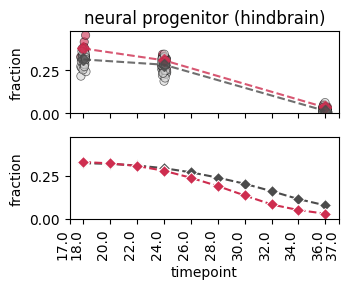

In [31]:
cell_type_selected = cell_types_selection[4]

df_subset1 = df_true[df_true["cell_type_broad"] == cell_type_selected]
df_subset2 = df_pred[df_pred["cell_type_broad"] == cell_type_selected]

df_highlight = df_subset1[df_subset1["Oligo"]=="total"]



all_timepoints = np.linspace(18, 36, 10)
all_timepoints = np.array([17.0] + list(all_timepoints) + [37.0])

jitter_strength = 0.2  # Adjust this value as needed

# Copy dataframe and add jitter to x-axis
df_subset_jittered = df_subset1.copy()
df_subset_jittered["timepoint_jittered"] = df_subset1["timepoint"] + np.random.uniform(-jitter_strength, jitter_strength, size=len(df_subset1))

# Define explicit y-range based on both datasets
ymin = 0.0 #min(df_subset["fraction"].min(), df_subset2["fraction"].min()) * 0.95  # Add slight buffer
ymax = max(df_subset1["fraction"].max(), df_subset2["fraction"].max()) * 1.05  # Add slight buffer

# Create figure with two subplots (stacked)
fig, axes = plt.subplots(2, 1, figsize=(3.5, 3), sharex=True, sharey=True)

### **Upper Plot: Scatter + Line Overlay**
ax1 = axes[0]

# Scatter plot with jittered x-values
sns.scatterplot(
    data=df_subset_jittered,
    x="timepoint_jittered",
    y="fraction",
    hue="gene_target",
    alpha=0.6, 
    edgecolor="black", 
    palette={"control_control": "#D6D6D6", "cdx4_cdx1a": "#CE2D4F"}, 
    linewidth=0.5,
    legend=False,
    ax=ax1
)

# Overlay line plot
for gene_target, df_group in df_highlight.groupby("gene_target"):
    color = color_d[gene_target]
    x_values = df_group["timepoint"]
    y_values = df_group["fraction"]

    # Sort by x-values to ensure correct line plotting order
    sorted_indices = np.argsort(x_values)
    x_values = np.array(x_values)[sorted_indices]
    y_values = np.array(y_values)[sorted_indices]


    ax1.plot(x_values, y_values, marker="D", linestyle="--", color=color, alpha=0.8)

### **Lower Plot: Line Plot Based on df_subset2**
ax2 = axes[1]

sns.lineplot(
    data=df_subset2,
    x="timepoint",
    y="fraction",
    hue="mode",
    marker="D",
    linestyle="--",
    palette=color_d,
    alpha=1.0,
    legend=False,
    ax=ax2
)

# Apply explicit x/y limits
ax1.set_xlim([all_timepoints.min(), all_timepoints.max()])
ax2.set_xlim([all_timepoints.min(), all_timepoints.max()])
ax1.set_ylim([ymin, ymax])
ax2.set_ylim([ymin, ymax])

# Format x-axis ticks correctly
ax2.set_xticks(all_timepoints)
ax2.set_xticklabels([f"{t:.1f}" for t in all_timepoints], rotation=90, ha="right")

# Remove x-tick labels from the upper plot to avoid redundancy
ax1.set_xticklabels(all_timepoints)
ax1.set_title(f"{cell_type_selected}")

cell_type_selected = cell_type_selected.replace(" ","_").replace("/", "_")
fig.savefig(os.path.join(output_dir, f"{cell_type_selected}_evolution.pdf"), dpi=300, bbox_inches="tight")

plt.tight_layout()
plt.show()


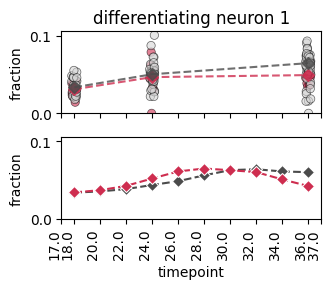

In [32]:
cell_type_selected = cell_types_selection[5]

df_subset1 = df_true[df_true["cell_type_broad"] == cell_type_selected]
df_subset2 = df_pred[df_pred["cell_type_broad"] == cell_type_selected]

df_highlight = df_subset1[df_subset1["Oligo"]=="total"]



all_timepoints = np.linspace(18, 36, 10)
all_timepoints = np.array([17.0] + list(all_timepoints) + [37.0])

jitter_strength = 0.2  # Adjust this value as needed

# Copy dataframe and add jitter to x-axis
df_subset_jittered = df_subset1.copy()
df_subset_jittered["timepoint_jittered"] = df_subset1["timepoint"] + np.random.uniform(-jitter_strength, jitter_strength, size=len(df_subset1))

# Define explicit y-range based on both datasets
ymin = 0.0 #min(df_subset["fraction"].min(), df_subset2["fraction"].min()) * 0.95  # Add slight buffer
ymax = max(df_subset1["fraction"].max(), df_subset2["fraction"].max()) * 1.05  # Add slight buffer

# Create figure with two subplots (stacked)
fig, axes = plt.subplots(2, 1, figsize=(3.5, 3), sharex=True, sharey=True)

### **Upper Plot: Scatter + Line Overlay**
ax1 = axes[0]

# Scatter plot with jittered x-values
sns.scatterplot(
    data=df_subset_jittered,
    x="timepoint_jittered",
    y="fraction",
    hue="gene_target",
    alpha=0.6, 
    edgecolor="black", 
    palette={"control_control": "#D6D6D6", "cdx4_cdx1a": "#CE2D4F"}, 
    linewidth=0.5,
    legend=False,
    ax=ax1
)

# Overlay line plot
for gene_target, df_group in df_highlight.groupby("gene_target"):
    color = color_d[gene_target]
    x_values = df_group["timepoint"]
    y_values = df_group["fraction"]

    # Sort by x-values to ensure correct line plotting order
    sorted_indices = np.argsort(x_values)
    x_values = np.array(x_values)[sorted_indices]
    y_values = np.array(y_values)[sorted_indices]


    ax1.plot(x_values, y_values, marker="D", linestyle="--", color=color, alpha=0.8)

### **Lower Plot: Line Plot Based on df_subset2**
ax2 = axes[1]

sns.lineplot(
    data=df_subset2,
    x="timepoint",
    y="fraction",
    hue="mode",
    marker="D",
    linestyle="--",
    palette=color_d,
    alpha=1.0,
    legend=False,
    ax=ax2
)

# Apply explicit x/y limits
ax1.set_xlim([all_timepoints.min(), all_timepoints.max()])
ax2.set_xlim([all_timepoints.min(), all_timepoints.max()])
ax1.set_ylim([ymin, ymax])
ax2.set_ylim([ymin, ymax])

# Format x-axis ticks correctly
ax2.set_xticks(all_timepoints)
ax2.set_xticklabels([f"{t:.1f}" for t in all_timepoints], rotation=90, ha="right")

# Remove x-tick labels from the upper plot to avoid redundancy
ax1.set_xticklabels(all_timepoints)
ax1.set_title(f"{cell_type_selected}")

cell_type_selected = cell_type_selected.replace(" ","_").replace("/", "_")
fig.savefig(os.path.join(output_dir, f"{cell_type_selected}_evolution.pdf"), dpi=300, bbox_inches="tight")

plt.tight_layout()
plt.show()


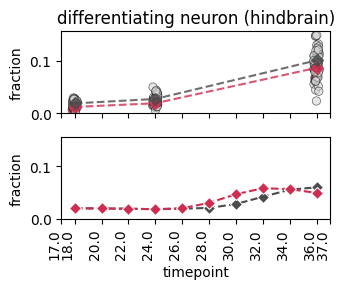

In [33]:
cell_type_selected = cell_types_selection[6]

df_subset1 = df_true[df_true["cell_type_broad"] == cell_type_selected]
df_subset2 = df_pred[df_pred["cell_type_broad"] == cell_type_selected]

df_highlight = df_subset1[df_subset1["Oligo"]=="total"]



all_timepoints = np.linspace(18, 36, 10)
all_timepoints = np.array([17.0] + list(all_timepoints) + [37.0])

jitter_strength = 0.2  # Adjust this value as needed

# Copy dataframe and add jitter to x-axis
df_subset_jittered = df_subset1.copy()
df_subset_jittered["timepoint_jittered"] = df_subset1["timepoint"] + np.random.uniform(-jitter_strength, jitter_strength, size=len(df_subset1))

# Define explicit y-range based on both datasets
ymin = 0.0 #min(df_subset["fraction"].min(), df_subset2["fraction"].min()) * 0.95  # Add slight buffer
ymax = max(df_subset1["fraction"].max(), df_subset2["fraction"].max()) * 1.05  # Add slight buffer

# Create figure with two subplots (stacked)
fig, axes = plt.subplots(2, 1, figsize=(3.5, 3), sharex=True, sharey=True)

### **Upper Plot: Scatter + Line Overlay**
ax1 = axes[0]

# Scatter plot with jittered x-values
sns.scatterplot(
    data=df_subset_jittered,
    x="timepoint_jittered",
    y="fraction",
    hue="gene_target",
    alpha=0.6, 
    edgecolor="black", 
    palette={"control_control": "#D6D6D6", "cdx4_cdx1a": "#CE2D4F"}, 
    linewidth=0.5,
    legend=False,
    ax=ax1
)

# Overlay line plot
for gene_target, df_group in df_highlight.groupby("gene_target"):
    color = color_d[gene_target]
    x_values = df_group["timepoint"]
    y_values = df_group["fraction"]

    # Sort by x-values to ensure correct line plotting order
    sorted_indices = np.argsort(x_values)
    x_values = np.array(x_values)[sorted_indices]
    y_values = np.array(y_values)[sorted_indices]


    ax1.plot(x_values, y_values, marker="D", linestyle="--", color=color, alpha=0.8)

### **Lower Plot: Line Plot Based on df_subset2**
ax2 = axes[1]

sns.lineplot(
    data=df_subset2,
    x="timepoint",
    y="fraction",
    hue="mode",
    marker="D",
    linestyle="--",
    palette=color_d,
    alpha=1.0,
    legend=False,
    ax=ax2
)

# Apply explicit x/y limits
ax1.set_xlim([all_timepoints.min(), all_timepoints.max()])
ax2.set_xlim([all_timepoints.min(), all_timepoints.max()])
ax1.set_ylim([ymin, ymax])
ax2.set_ylim([ymin, ymax])

# Format x-axis ticks correctly
ax2.set_xticks(all_timepoints)
ax2.set_xticklabels([f"{t:.1f}" for t in all_timepoints], rotation=90, ha="right")

# Remove x-tick labels from the upper plot to avoid redundancy
ax1.set_xticklabels(all_timepoints)
ax1.set_title(f"{cell_type_selected}")

cell_type_selected = cell_type_selected.replace(" ","_").replace("/", "_")
fig.savefig(os.path.join(output_dir, f"{cell_type_selected}_evolution.pdf"), dpi=300, bbox_inches="tight")

plt.tight_layout()
plt.show()


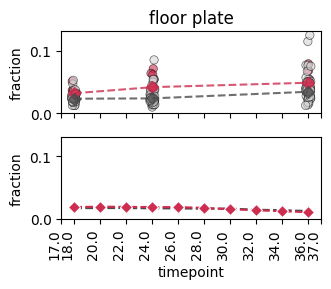

In [34]:
cell_type_selected = cell_types_selection[7]

df_subset1 = df_true[df_true["cell_type_broad"] == cell_type_selected]
df_subset2 = df_pred[df_pred["cell_type_broad"] == cell_type_selected]

df_highlight = df_subset1[df_subset1["Oligo"]=="total"]



all_timepoints = np.linspace(18, 36, 10)
all_timepoints = np.array([17.0] + list(all_timepoints) + [37.0])

jitter_strength = 0.2  # Adjust this value as needed

# Copy dataframe and add jitter to x-axis
df_subset_jittered = df_subset1.copy()
df_subset_jittered["timepoint_jittered"] = df_subset1["timepoint"] + np.random.uniform(-jitter_strength, jitter_strength, size=len(df_subset1))

# Define explicit y-range based on both datasets
ymin = 0.0 #min(df_subset["fraction"].min(), df_subset2["fraction"].min()) * 0.95  # Add slight buffer
ymax = max(df_subset1["fraction"].max(), df_subset2["fraction"].max()) * 1.05  # Add slight buffer

# Create figure with two subplots (stacked)
fig, axes = plt.subplots(2, 1, figsize=(3.5, 3), sharex=True, sharey=True)

### **Upper Plot: Scatter + Line Overlay**
ax1 = axes[0]

# Scatter plot with jittered x-values
sns.scatterplot(
    data=df_subset_jittered,
    x="timepoint_jittered",
    y="fraction",
    hue="gene_target",
    alpha=0.6, 
    edgecolor="black", 
    palette={"control_control": "#D6D6D6", "cdx4_cdx1a": "#CE2D4F"}, 
    linewidth=0.5,
    legend=False,
    ax=ax1
)

# Overlay line plot
for gene_target, df_group in df_highlight.groupby("gene_target"):
    color = color_d[gene_target]
    x_values = df_group["timepoint"]
    y_values = df_group["fraction"]

    # Sort by x-values to ensure correct line plotting order
    sorted_indices = np.argsort(x_values)
    x_values = np.array(x_values)[sorted_indices]
    y_values = np.array(y_values)[sorted_indices]


    ax1.plot(x_values, y_values, marker="D", linestyle="--", color=color, alpha=0.8)

### **Lower Plot: Line Plot Based on df_subset2**
ax2 = axes[1]

sns.lineplot(
    data=df_subset2,
    x="timepoint",
    y="fraction",
    hue="mode",
    marker="D",
    linestyle="--",
    palette=color_d,
    alpha=1.0,
    legend=False,
    ax=ax2
)

# Apply explicit x/y limits
ax1.set_xlim([all_timepoints.min(), all_timepoints.max()])
ax2.set_xlim([all_timepoints.min(), all_timepoints.max()])
ax1.set_ylim([ymin, ymax])
ax2.set_ylim([ymin, ymax])

# Format x-axis ticks correctly
ax2.set_xticks(all_timepoints)
ax2.set_xticklabels([f"{t:.1f}" for t in all_timepoints], rotation=90, ha="right")

# Remove x-tick labels from the upper plot to avoid redundancy
ax1.set_xticklabels(all_timepoints)
ax1.set_title(f"{cell_type_selected}")
cell_type_selected = cell_type_selected.replace(" ","_").replace("/", "_")
fig.savefig(os.path.join(output_dir, f"{cell_type_selected}_evolution.pdf"), dpi=300, bbox_inches="tight")

plt.tight_layout()
plt.show()


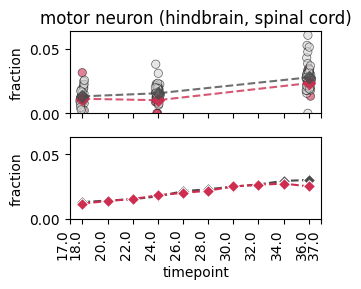

In [35]:
cell_type_selected = cell_types_selection[8]

df_subset1 = df_true[df_true["cell_type_broad"] == cell_type_selected]
df_subset2 = df_pred[df_pred["cell_type_broad"] == cell_type_selected]

df_highlight = df_subset1[df_subset1["Oligo"]=="total"]



all_timepoints = np.linspace(18, 36, 10)
all_timepoints = np.array([17.0] + list(all_timepoints) + [37.0])

jitter_strength = 0.2  # Adjust this value as needed

# Copy dataframe and add jitter to x-axis
df_subset_jittered = df_subset1.copy()
df_subset_jittered["timepoint_jittered"] = df_subset1["timepoint"] + np.random.uniform(-jitter_strength, jitter_strength, size=len(df_subset1))

# Define explicit y-range based on both datasets
ymin = 0.0 #min(df_subset["fraction"].min(), df_subset2["fraction"].min()) * 0.95  # Add slight buffer
ymax = max(df_subset1["fraction"].max(), df_subset2["fraction"].max()) * 1.05  # Add slight buffer

# Create figure with two subplots (stacked)
fig, axes = plt.subplots(2, 1, figsize=(3.5, 3), sharex=True, sharey=True)

### **Upper Plot: Scatter + Line Overlay**
ax1 = axes[0]

# Scatter plot with jittered x-values
sns.scatterplot(
    data=df_subset_jittered,
    x="timepoint_jittered",
    y="fraction",
    hue="gene_target",
    alpha=0.6, 
    edgecolor="black", 
    palette={"control_control": "#D6D6D6", "cdx4_cdx1a": "#CE2D4F"}, 
    linewidth=0.5,
    legend=False,
    ax=ax1
)

# Overlay line plot
for gene_target, df_group in df_highlight.groupby("gene_target"):
    color = color_d[gene_target]
    x_values = df_group["timepoint"]
    y_values = df_group["fraction"]

    # Sort by x-values to ensure correct line plotting order
    sorted_indices = np.argsort(x_values)
    x_values = np.array(x_values)[sorted_indices]
    y_values = np.array(y_values)[sorted_indices]


    ax1.plot(x_values, y_values, marker="D", linestyle="--", color=color, alpha=0.8)

### **Lower Plot: Line Plot Based on df_subset2**
ax2 = axes[1]

sns.lineplot(
    data=df_subset2,
    x="timepoint",
    y="fraction",
    hue="mode",
    marker="D",
    linestyle="--",
    palette=color_d,
    alpha=1.0,
    legend=False,
    ax=ax2
)

# Apply explicit x/y limits
ax1.set_xlim([all_timepoints.min(), all_timepoints.max()])
ax2.set_xlim([all_timepoints.min(), all_timepoints.max()])
ax1.set_ylim([ymin, ymax])
ax2.set_ylim([ymin, ymax])

# Format x-axis ticks correctly
ax2.set_xticks(all_timepoints)
ax2.set_xticklabels([f"{t:.1f}" for t in all_timepoints], rotation=90, ha="right")

# Remove x-tick labels from the upper plot to avoid redundancy
ax1.set_xticklabels(all_timepoints)
ax1.set_title(f"{cell_type_selected}")
cell_type_selected = cell_type_selected.replace(" ","_").replace("/", "_")
fig.savefig(os.path.join(output_dir, f"{cell_type_selected}_evolution.pdf"), dpi=300, bbox_inches="tight")

plt.tight_layout()
plt.show()


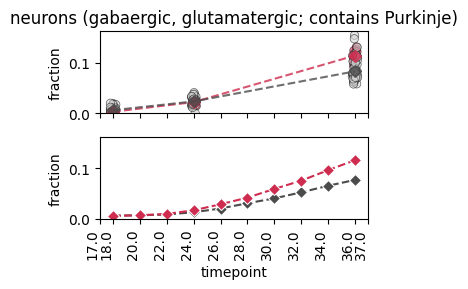

In [36]:
cell_type_selected = cell_types_selection[9]

df_subset1 = df_true[df_true["cell_type_broad"] == cell_type_selected]
df_subset2 = df_pred[df_pred["cell_type_broad"] == cell_type_selected]

df_highlight = df_subset1[df_subset1["Oligo"]=="total"]



all_timepoints = np.linspace(18, 36, 10)
all_timepoints = np.array([17.0] + list(all_timepoints) + [37.0])

jitter_strength = 0.2  # Adjust this value as needed

# Copy dataframe and add jitter to x-axis
df_subset_jittered = df_subset1.copy()
df_subset_jittered["timepoint_jittered"] = df_subset1["timepoint"] + np.random.uniform(-jitter_strength, jitter_strength, size=len(df_subset1))

# Define explicit y-range based on both datasets
ymin = 0.0 #min(df_subset["fraction"].min(), df_subset2["fraction"].min()) * 0.95  # Add slight buffer
ymax = max(df_subset1["fraction"].max(), df_subset2["fraction"].max()) * 1.05  # Add slight buffer

# Create figure with two subplots (stacked)
fig, axes = plt.subplots(2, 1, figsize=(3.5, 3), sharex=True, sharey=True)

### **Upper Plot: Scatter + Line Overlay**
ax1 = axes[0]

# Scatter plot with jittered x-values
sns.scatterplot(
    data=df_subset_jittered,
    x="timepoint_jittered",
    y="fraction",
    hue="gene_target",
    alpha=0.6, 
    edgecolor="black", 
    palette={"control_control": "#D6D6D6", "cdx4_cdx1a": "#CE2D4F"}, 
    linewidth=0.5,
    legend=False,
    ax=ax1
)

# Overlay line plot
for gene_target, df_group in df_highlight.groupby("gene_target"):
    color = color_d[gene_target]
    x_values = df_group["timepoint"]
    y_values = df_group["fraction"]

    # Sort by x-values to ensure correct line plotting order
    sorted_indices = np.argsort(x_values)
    x_values = np.array(x_values)[sorted_indices]
    y_values = np.array(y_values)[sorted_indices]


    ax1.plot(x_values, y_values, marker="D", linestyle="--", color=color, alpha=0.8)

### **Lower Plot: Line Plot Based on df_subset2**
ax2 = axes[1]

sns.lineplot(
    data=df_subset2,
    x="timepoint",
    y="fraction",
    hue="mode",
    marker="D",
    linestyle="--",
    palette=color_d,
    alpha=1.0,
    legend=False,
    ax=ax2
)

# Apply explicit x/y limits
ax1.set_xlim([all_timepoints.min(), all_timepoints.max()])
ax2.set_xlim([all_timepoints.min(), all_timepoints.max()])
ax1.set_ylim([ymin, ymax])
ax2.set_ylim([ymin, ymax])

# Format x-axis ticks correctly
ax2.set_xticks(all_timepoints)
ax2.set_xticklabels([f"{t:.1f}" for t in all_timepoints], rotation=90, ha="right")

# Remove x-tick labels from the upper plot to avoid redundancy
ax1.set_xticklabels(all_timepoints)
ax1.set_title(f"{cell_type_selected}")
cell_type_selected = cell_type_selected.replace(" ","_").replace("/", "_")
fig.savefig(os.path.join(output_dir, f"{cell_type_selected}_evolution.pdf"), dpi=300, bbox_inches="tight")

plt.tight_layout()
plt.show()


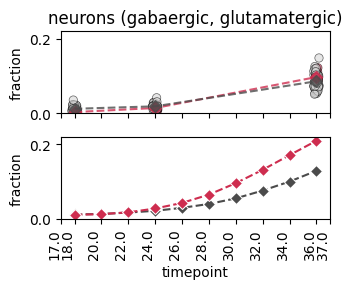

In [37]:
cell_type_selected = cell_types_selection[10]

df_subset1 = df_true[df_true["cell_type_broad"] == cell_type_selected]
df_subset2 = df_pred[df_pred["cell_type_broad"] == cell_type_selected]

df_highlight = df_subset1[df_subset1["Oligo"]=="total"]



all_timepoints = np.linspace(18, 36, 10)
all_timepoints = np.array([17.0] + list(all_timepoints) + [37.0])

jitter_strength = 0.2  # Adjust this value as needed

# Copy dataframe and add jitter to x-axis
df_subset_jittered = df_subset1.copy()
df_subset_jittered["timepoint_jittered"] = df_subset1["timepoint"] + np.random.uniform(-jitter_strength, jitter_strength, size=len(df_subset1))

# Define explicit y-range based on both datasets
ymin = 0.0 #min(df_subset["fraction"].min(), df_subset2["fraction"].min()) * 0.95  # Add slight buffer
ymax = max(df_subset1["fraction"].max(), df_subset2["fraction"].max()) * 1.05  # Add slight buffer

# Create figure with two subplots (stacked)
fig, axes = plt.subplots(2, 1, figsize=(3.5, 3), sharex=True, sharey=True)

### **Upper Plot: Scatter + Line Overlay**
ax1 = axes[0]

# Scatter plot with jittered x-values
sns.scatterplot(
    data=df_subset_jittered,
    x="timepoint_jittered",
    y="fraction",
    hue="gene_target",
    alpha=0.6, 
    edgecolor="black", 
    palette={"control_control": "#D6D6D6", "cdx4_cdx1a": "#CE2D4F"}, 
    linewidth=0.5,
    legend=False,
    ax=ax1
)

# Overlay line plot
for gene_target, df_group in df_highlight.groupby("gene_target"):
    color = color_d[gene_target]
    x_values = df_group["timepoint"]
    y_values = df_group["fraction"]

    # Sort by x-values to ensure correct line plotting order
    sorted_indices = np.argsort(x_values)
    x_values = np.array(x_values)[sorted_indices]
    y_values = np.array(y_values)[sorted_indices]


    ax1.plot(x_values, y_values, marker="D", linestyle="--", color=color, alpha=0.8)

### **Lower Plot: Line Plot Based on df_subset2**
ax2 = axes[1]

sns.lineplot(
    data=df_subset2,
    x="timepoint",
    y="fraction",
    hue="mode",
    marker="D",
    linestyle="--",
    palette=color_d,
    alpha=1.0,
    legend=False,
    ax=ax2
)

# Apply explicit x/y limits
ax1.set_xlim([all_timepoints.min(), all_timepoints.max()])
ax2.set_xlim([all_timepoints.min(), all_timepoints.max()])
ax1.set_ylim([ymin, ymax])
ax2.set_ylim([ymin, ymax])

# Format x-axis ticks correctly
ax2.set_xticks(all_timepoints)
ax2.set_xticklabels([f"{t:.1f}" for t in all_timepoints], rotation=90, ha="right")

# Remove x-tick labels from the upper plot to avoid redundancy
ax1.set_xticklabels(all_timepoints)
ax1.set_title(f"{cell_type_selected}")
cell_type_selected = cell_type_selected.replace(" ","_").replace("/", "_")
fig.savefig(os.path.join(output_dir, f"{cell_type_selected}_evolution.pdf"), dpi=300, bbox_inches="tight")

plt.tight_layout()
plt.show()


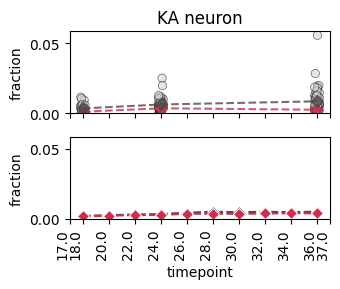

In [38]:
cell_type_selected = cell_types_selection[11]

df_subset1 = df_true[df_true["cell_type_broad"] == cell_type_selected]
df_subset2 = df_pred[df_pred["cell_type_broad"] == cell_type_selected]

df_highlight = df_subset1[df_subset1["Oligo"]=="total"]



all_timepoints = np.linspace(18, 36, 10)
all_timepoints = np.array([17.0] + list(all_timepoints) + [37.0])

jitter_strength = 0.2  # Adjust this value as needed

# Copy dataframe and add jitter to x-axis
df_subset_jittered = df_subset1.copy()
df_subset_jittered["timepoint_jittered"] = df_subset1["timepoint"] + np.random.uniform(-jitter_strength, jitter_strength, size=len(df_subset1))

# Define explicit y-range based on both datasets
ymin = 0.0 #min(df_subset["fraction"].min(), df_subset2["fraction"].min()) * 0.95  # Add slight buffer
ymax = max(df_subset1["fraction"].max(), df_subset2["fraction"].max()) * 1.05  # Add slight buffer

# Create figure with two subplots (stacked)
fig, axes = plt.subplots(2, 1, figsize=(3.5, 3), sharex=True, sharey=True)

### **Upper Plot: Scatter + Line Overlay**
ax1 = axes[0]

# Scatter plot with jittered x-values
sns.scatterplot(
    data=df_subset_jittered,
    x="timepoint_jittered",
    y="fraction",
    hue="gene_target",
    alpha=0.6, 
    edgecolor="black", 
    palette={"control_control": "#D6D6D6", "cdx4_cdx1a": "#CE2D4F"}, 
    linewidth=0.5,
    legend=False,
    ax=ax1
)

# Overlay line plot
for gene_target, df_group in df_highlight.groupby("gene_target"):
    color = color_d[gene_target]
    x_values = df_group["timepoint"]
    y_values = df_group["fraction"]

    # Sort by x-values to ensure correct line plotting order
    sorted_indices = np.argsort(x_values)
    x_values = np.array(x_values)[sorted_indices]
    y_values = np.array(y_values)[sorted_indices]


    ax1.plot(x_values, y_values, marker="D", linestyle="--", color=color, alpha=0.8)

### **Lower Plot: Line Plot Based on df_subset2**
ax2 = axes[1]

sns.lineplot(
    data=df_subset2,
    x="timepoint",
    y="fraction",
    hue="mode",
    marker="D",
    linestyle="--",
    palette=color_d,
    alpha=1.0,
    legend=False,
    ax=ax2
)

# Apply explicit x/y limits
ax1.set_xlim([all_timepoints.min(), all_timepoints.max()])
ax2.set_xlim([all_timepoints.min(), all_timepoints.max()])
ax1.set_ylim([ymin, ymax])
ax2.set_ylim([ymin, ymax])

# Format x-axis ticks correctly
ax2.set_xticks(all_timepoints)
ax2.set_xticklabels([f"{t:.1f}" for t in all_timepoints], rotation=90, ha="right")

# Remove x-tick labels from the upper plot to avoid redundancy
ax1.set_xticklabels(all_timepoints)
ax1.set_title(f"{cell_type_selected}")
cell_type_selected = cell_type_selected.replace(" ","_").replace("/", "_")
fig.savefig(os.path.join(output_dir, f"{cell_type_selected}_evolution.pdf"), dpi=300, bbox_inches="tight")

plt.tight_layout()
plt.show()


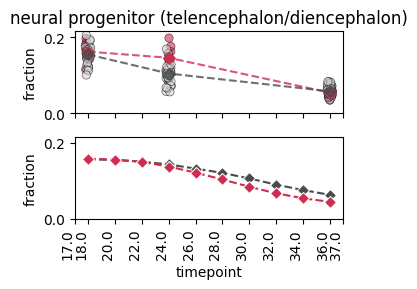

In [39]:
cell_type_selected = cell_types_selection[12]

df_subset1 = df_true[df_true["cell_type_broad"] == cell_type_selected]
df_subset2 = df_pred[df_pred["cell_type_broad"] == cell_type_selected]

df_highlight = df_subset1[df_subset1["Oligo"]=="total"]



all_timepoints = np.linspace(18, 36, 10)
all_timepoints = np.array([17.0] + list(all_timepoints) + [37.0])

jitter_strength = 0.2  # Adjust this value as needed

# Copy dataframe and add jitter to x-axis
df_subset_jittered = df_subset1.copy()
df_subset_jittered["timepoint_jittered"] = df_subset1["timepoint"] + np.random.uniform(-jitter_strength, jitter_strength, size=len(df_subset1))

# Define explicit y-range based on both datasets
ymin = 0.0 #min(df_subset["fraction"].min(), df_subset2["fraction"].min()) * 0.95  # Add slight buffer
ymax = max(df_subset1["fraction"].max(), df_subset2["fraction"].max()) * 1.05  # Add slight buffer

# Create figure with two subplots (stacked)
fig, axes = plt.subplots(2, 1, figsize=(3.5, 3), sharex=True, sharey=True)

### **Upper Plot: Scatter + Line Overlay**
ax1 = axes[0]

# Scatter plot with jittered x-values
sns.scatterplot(
    data=df_subset_jittered,
    x="timepoint_jittered",
    y="fraction",
    hue="gene_target",
    alpha=0.6, 
    edgecolor="black", 
    palette={"control_control": "#D6D6D6", "cdx4_cdx1a": "#CE2D4F"}, 
    linewidth=0.5,
    legend=False,
    ax=ax1
)

# Overlay line plot
for gene_target, df_group in df_highlight.groupby("gene_target"):
    color = color_d[gene_target]
    x_values = df_group["timepoint"]
    y_values = df_group["fraction"]

    # Sort by x-values to ensure correct line plotting order
    sorted_indices = np.argsort(x_values)
    x_values = np.array(x_values)[sorted_indices]
    y_values = np.array(y_values)[sorted_indices]


    ax1.plot(x_values, y_values, marker="D", linestyle="--", color=color, alpha=0.8)

### **Lower Plot: Line Plot Based on df_subset2**
ax2 = axes[1]

sns.lineplot(
    data=df_subset2,
    x="timepoint",
    y="fraction",
    hue="mode",
    marker="D",
    linestyle="--",
    palette=color_d,
    alpha=1.0,
    legend=False,
    ax=ax2
)

# Apply explicit x/y limits
ax1.set_xlim([all_timepoints.min(), all_timepoints.max()])
ax2.set_xlim([all_timepoints.min(), all_timepoints.max()])
ax1.set_ylim([ymin, ymax])
ax2.set_ylim([ymin, ymax])

# Format x-axis ticks correctly
ax2.set_xticks(all_timepoints)
ax2.set_xticklabels([f"{t:.1f}" for t in all_timepoints], rotation=90, ha="right")

# Remove x-tick labels from the upper plot to avoid redundancy
ax1.set_xticklabels(all_timepoints)
ax1.set_title(f"{cell_type_selected}")
cell_type_selected = cell_type_selected.replace(" ","_").replace("/", "_")
fig.savefig(os.path.join(output_dir, f"{cell_type_selected}_evolution.pdf"), dpi=300, bbox_inches="tight")

plt.tight_layout()
plt.show()


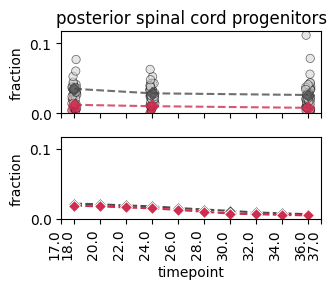

In [40]:
cell_type_selected = cell_types_selection[13]

df_subset1 = df_true[df_true["cell_type_broad"] == cell_type_selected]
df_subset2 = df_pred[df_pred["cell_type_broad"] == cell_type_selected]

df_highlight = df_subset1[df_subset1["Oligo"]=="total"]



all_timepoints = np.linspace(18, 36, 10)
all_timepoints = np.array([17.0] + list(all_timepoints) + [37.0])

jitter_strength = 0.2  # Adjust this value as needed

# Copy dataframe and add jitter to x-axis
df_subset_jittered = df_subset1.copy()
df_subset_jittered["timepoint_jittered"] = df_subset1["timepoint"] + np.random.uniform(-jitter_strength, jitter_strength, size=len(df_subset1))

# Define explicit y-range based on both datasets
ymin = 0.0 #min(df_subset["fraction"].min(), df_subset2["fraction"].min()) * 0.95  # Add slight buffer
ymax = max(df_subset1["fraction"].max(), df_subset2["fraction"].max()) * 1.05  # Add slight buffer

# Create figure with two subplots (stacked)
fig, axes = plt.subplots(2, 1, figsize=(3.5, 3), sharex=True, sharey=True)

### **Upper Plot: Scatter + Line Overlay**
ax1 = axes[0]

# Scatter plot with jittered x-values
sns.scatterplot(
    data=df_subset_jittered,
    x="timepoint_jittered",
    y="fraction",
    hue="gene_target",
    alpha=0.6, 
    edgecolor="black", 
    palette={"control_control": "#D6D6D6", "cdx4_cdx1a": "#CE2D4F"}, 
    linewidth=0.5,
    legend=False,
    ax=ax1
)

# Overlay line plot
for gene_target, df_group in df_highlight.groupby("gene_target"):
    color = color_d[gene_target]
    x_values = df_group["timepoint"]
    y_values = df_group["fraction"]

    # Sort by x-values to ensure correct line plotting order
    sorted_indices = np.argsort(x_values)
    x_values = np.array(x_values)[sorted_indices]
    y_values = np.array(y_values)[sorted_indices]


    ax1.plot(x_values, y_values, marker="D", linestyle="--", color=color, alpha=0.8)

### **Lower Plot: Line Plot Based on df_subset2**
ax2 = axes[1]

sns.lineplot(
    data=df_subset2,
    x="timepoint",
    y="fraction",
    hue="mode",
    marker="D",
    linestyle="--",
    palette=color_d,
    alpha=1.0,
    legend=False,
    ax=ax2
)

# Apply explicit x/y limits
ax1.set_xlim([all_timepoints.min(), all_timepoints.max()])
ax2.set_xlim([all_timepoints.min(), all_timepoints.max()])
ax1.set_ylim([ymin, ymax])
ax2.set_ylim([ymin, ymax])

# Format x-axis ticks correctly
ax2.set_xticks(all_timepoints)
ax2.set_xticklabels([f"{t:.1f}" for t in all_timepoints], rotation=90, ha="right")

# Remove x-tick labels from the upper plot to avoid redundancy
ax1.set_xticklabels(all_timepoints)
ax1.set_title(f"{cell_type_selected}")
cell_type_selected = cell_type_selected.replace(" ","_").replace("/", "_")
fig.savefig(os.path.join(output_dir, f"{cell_type_selected}_evolution.pdf"), dpi=300, bbox_inches="tight")

plt.tight_layout()
plt.show()


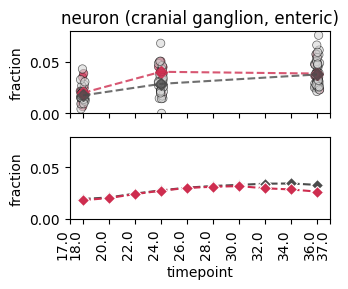

In [41]:
cell_type_selected = cell_types_selection[14]

df_subset1 = df_true[df_true["cell_type_broad"] == cell_type_selected]
df_subset2 = df_pred[df_pred["cell_type_broad"] == cell_type_selected]

df_highlight = df_subset1[df_subset1["Oligo"]=="total"]



all_timepoints = np.linspace(18, 36, 10)
all_timepoints = np.array([17.0] + list(all_timepoints) + [37.0])

jitter_strength = 0.2  # Adjust this value as needed

# Copy dataframe and add jitter to x-axis
df_subset_jittered = df_subset1.copy()
df_subset_jittered["timepoint_jittered"] = df_subset1["timepoint"] + np.random.uniform(-jitter_strength, jitter_strength, size=len(df_subset1))

# Define explicit y-range based on both datasets
ymin = 0.0 #min(df_subset["fraction"].min(), df_subset2["fraction"].min()) * 0.95  # Add slight buffer
ymax = max(df_subset1["fraction"].max(), df_subset2["fraction"].max()) * 1.05  # Add slight buffer

# Create figure with two subplots (stacked)
fig, axes = plt.subplots(2, 1, figsize=(3.5, 3), sharex=True, sharey=True)

### **Upper Plot: Scatter + Line Overlay**
ax1 = axes[0]

# Scatter plot with jittered x-values
sns.scatterplot(
    data=df_subset_jittered,
    x="timepoint_jittered",
    y="fraction",
    hue="gene_target",
    alpha=0.6, 
    edgecolor="black", 
    palette={"control_control": "#D6D6D6", "cdx4_cdx1a": "#CE2D4F"}, 
    linewidth=0.5,
    legend=False,
    ax=ax1
)

# Overlay line plot
for gene_target, df_group in df_highlight.groupby("gene_target"):
    color = color_d[gene_target]
    x_values = df_group["timepoint"]
    y_values = df_group["fraction"]

    # Sort by x-values to ensure correct line plotting order
    sorted_indices = np.argsort(x_values)
    x_values = np.array(x_values)[sorted_indices]
    y_values = np.array(y_values)[sorted_indices]


    ax1.plot(x_values, y_values, marker="D", linestyle="--", color=color, alpha=0.8)

### **Lower Plot: Line Plot Based on df_subset2**
ax2 = axes[1]

sns.lineplot(
    data=df_subset2,
    x="timepoint",
    y="fraction",
    hue="mode",
    marker="D",
    linestyle="--",
    palette=color_d,
    alpha=1.0,
    legend=False,
    ax=ax2
)

# Apply explicit x/y limits
ax1.set_xlim([all_timepoints.min(), all_timepoints.max()])
ax2.set_xlim([all_timepoints.min(), all_timepoints.max()])
ax1.set_ylim([ymin, ymax])
ax2.set_ylim([ymin, ymax])

# Format x-axis ticks correctly
ax2.set_xticks(all_timepoints)
ax2.set_xticklabels([f"{t:.1f}" for t in all_timepoints], rotation=90, ha="right")

# Remove x-tick labels from the upper plot to avoid redundancy
ax1.set_xticklabels(all_timepoints)
ax1.set_title(f"{cell_type_selected}")
cell_type_selected = cell_type_selected.replace(" ","_").replace("/", "_")
fig.savefig(os.path.join(output_dir, f"{cell_type_selected}_evolution.pdf"), dpi=300, bbox_inches="tight")

plt.tight_layout()
plt.show()


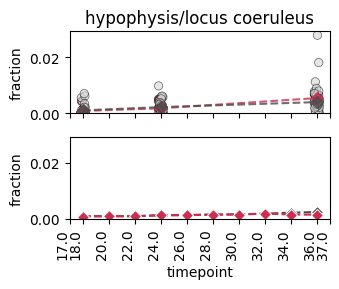

In [42]:
cell_type_selected = cell_types_selection[15]

df_subset1 = df_true[df_true["cell_type_broad"] == cell_type_selected]
df_subset2 = df_pred[df_pred["cell_type_broad"] == cell_type_selected]

df_highlight = df_subset1[df_subset1["Oligo"]=="total"]



all_timepoints = np.linspace(18, 36, 10)
all_timepoints = np.array([17.0] + list(all_timepoints) + [37.0])

jitter_strength = 0.2  # Adjust this value as needed

# Copy dataframe and add jitter to x-axis
df_subset_jittered = df_subset1.copy()
df_subset_jittered["timepoint_jittered"] = df_subset1["timepoint"] + np.random.uniform(-jitter_strength, jitter_strength, size=len(df_subset1))

# Define explicit y-range based on both datasets
ymin = 0.0 #min(df_subset["fraction"].min(), df_subset2["fraction"].min()) * 0.95  # Add slight buffer
ymax = max(df_subset1["fraction"].max(), df_subset2["fraction"].max()) * 1.05  # Add slight buffer

# Create figure with two subplots (stacked)
fig, axes = plt.subplots(2, 1, figsize=(3.5, 3), sharex=True, sharey=True)

### **Upper Plot: Scatter + Line Overlay**
ax1 = axes[0]

# Scatter plot with jittered x-values
sns.scatterplot(
    data=df_subset_jittered,
    x="timepoint_jittered",
    y="fraction",
    hue="gene_target",
    alpha=0.6, 
    edgecolor="black", 
    palette={"control_control": "#D6D6D6", "cdx4_cdx1a": "#CE2D4F"}, 
    linewidth=0.5,
    legend=False,
    ax=ax1
)

# Overlay line plot
for gene_target, df_group in df_highlight.groupby("gene_target"):
    color = color_d[gene_target]
    x_values = df_group["timepoint"]
    y_values = df_group["fraction"]

    # Sort by x-values to ensure correct line plotting order
    sorted_indices = np.argsort(x_values)
    x_values = np.array(x_values)[sorted_indices]
    y_values = np.array(y_values)[sorted_indices]


    ax1.plot(x_values, y_values, marker="D", linestyle="--", color=color, alpha=0.8)

### **Lower Plot: Line Plot Based on df_subset2**
ax2 = axes[1]

sns.lineplot(
    data=df_subset2,
    x="timepoint",
    y="fraction",
    hue="mode",
    marker="D",
    linestyle="--",
    palette=color_d,
    alpha=1.0,
    legend=False,
    ax=ax2
)

# Apply explicit x/y limits
ax1.set_xlim([all_timepoints.min(), all_timepoints.max()])
ax2.set_xlim([all_timepoints.min(), all_timepoints.max()])
ax1.set_ylim([ymin, ymax])
ax2.set_ylim([ymin, ymax])

# Format x-axis ticks correctly
ax2.set_xticks(all_timepoints)
ax2.set_xticklabels([f"{t:.1f}" for t in all_timepoints], rotation=90, ha="right")

# Remove x-tick labels from the upper plot to avoid redundancy
ax1.set_xticklabels(all_timepoints)
ax1.set_title(f"{cell_type_selected}")
cell_type_selected = cell_type_selected.replace(" ","_").replace("/", "_")
fig.savefig(os.path.join(output_dir, f"{cell_type_selected}_evolution.pdf"), dpi=300, bbox_inches="tight")

plt.tight_layout()
plt.show()


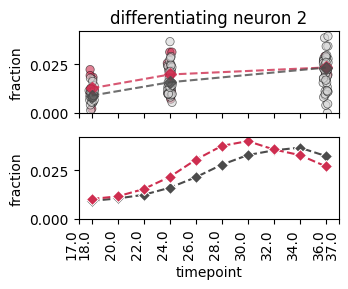

In [43]:
cell_type_selected = cell_types_selection[16]

df_subset1 = df_true[df_true["cell_type_broad"] == cell_type_selected]
df_subset2 = df_pred[df_pred["cell_type_broad"] == cell_type_selected]

df_highlight = df_subset1[df_subset1["Oligo"]=="total"]



all_timepoints = np.linspace(18, 36, 10)
all_timepoints = np.array([17.0] + list(all_timepoints) + [37.0])

jitter_strength = 0.2  # Adjust this value as needed

# Copy dataframe and add jitter to x-axis
df_subset_jittered = df_subset1.copy()
df_subset_jittered["timepoint_jittered"] = df_subset1["timepoint"] + np.random.uniform(-jitter_strength, jitter_strength, size=len(df_subset1))

# Define explicit y-range based on both datasets
ymin = 0.0 #min(df_subset["fraction"].min(), df_subset2["fraction"].min()) * 0.95  # Add slight buffer
ymax = max(df_subset1["fraction"].max(), df_subset2["fraction"].max()) * 1.05  # Add slight buffer

# Create figure with two subplots (stacked)
fig, axes = plt.subplots(2, 1, figsize=(3.5, 3), sharex=True, sharey=True)

### **Upper Plot: Scatter + Line Overlay**
ax1 = axes[0]

# Scatter plot with jittered x-values
sns.scatterplot(
    data=df_subset_jittered,
    x="timepoint_jittered",
    y="fraction",
    hue="gene_target",
    alpha=0.6, 
    edgecolor="black", 
    palette={"control_control": "#D6D6D6", "cdx4_cdx1a": "#CE2D4F"}, 
    linewidth=0.5,
    legend=False,
    ax=ax1
)

# Overlay line plot
for gene_target, df_group in df_highlight.groupby("gene_target"):
    color = color_d[gene_target]
    x_values = df_group["timepoint"]
    y_values = df_group["fraction"]

    # Sort by x-values to ensure correct line plotting order
    sorted_indices = np.argsort(x_values)
    x_values = np.array(x_values)[sorted_indices]
    y_values = np.array(y_values)[sorted_indices]


    ax1.plot(x_values, y_values, marker="D", linestyle="--", color=color, alpha=0.8)

### **Lower Plot: Line Plot Based on df_subset2**
ax2 = axes[1]

sns.lineplot(
    data=df_subset2,
    x="timepoint",
    y="fraction",
    hue="mode",
    marker="D",
    linestyle="--",
    palette=color_d,
    alpha=1.0,
    legend=False,
    ax=ax2
)

# Apply explicit x/y limits
ax1.set_xlim([all_timepoints.min(), all_timepoints.max()])
ax2.set_xlim([all_timepoints.min(), all_timepoints.max()])
ax1.set_ylim([ymin, ymax])
ax2.set_ylim([ymin, ymax])

# Format x-axis ticks correctly
ax2.set_xticks(all_timepoints)
ax2.set_xticklabels([f"{t:.1f}" for t in all_timepoints], rotation=90, ha="right")

# Remove x-tick labels from the upper plot to avoid redundancy
ax1.set_xticklabels(all_timepoints)
ax1.set_title(f"{cell_type_selected}")
cell_type_selected = cell_type_selected.replace(" ","_").replace("/", "_")
fig.savefig(os.path.join(output_dir, f"{cell_type_selected}_evolution.pdf"), dpi=300, bbox_inches="tight")

plt.tight_layout()
plt.show()
